In [36]:
import sympy as sym
import numpy as np
import pandas as pd
from scipy.linalg import eig
import sympy.physics.mechanics as me
from sympy.physics.vector.printing import vpprint, vlatex
from sympy.utilities.codegen import codegen
from sympy.utilities.autowrap import autowrap
from dataclasses import dataclass, InitVar, field
from sympy.abc import x,y,t

from FwtModels import AssumedShapes

# Wing Parameters

In [37]:
semiSpan = 1.345  # semi-span of the wing
ratioFwt = 0.29   # ratio of the wing semi span that is fwt
chord = 0.15
FwtMassPerUnitArea = 0.597/(semiSpan*ratioFwt*chord)

# with width b and hieght h
h = 0.005 # hieght of bar
b = 0.03 # width of bar
I_xx = b*h**3/12
I_yy = b**3*h/12
J = I_xx + I_yy



# Material properties
E = 190e9
G = 74e9
Density = 8000

WingMassPerUnitArea = 8000*h*b/chord # convert to uniform mass over a chord 

# create an instance of the class holding all the properties for the FWT
p = AssumedShapes.FwtParameters(m_w = WingMassPerUnitArea,
                        m_t = FwtMassPerUnitArea,
                        x_f = 0.25,
                        s_w = semiSpan*(1-ratioFwt),
                        s_t = semiSpan*ratioFwt,
                        c = chord,
                        Lambda = np.deg2rad(10),
                        EI = E*I_xx,
                        GJ = G*J,
                        k_theta = 0,
                        rho = 1.225,
                        V = 10,
                        a_w = 2*np.pi,
                        a_t = 2*np.pi,
                        alpha_0 = 0,
                        e = 0.25,
                        Malphadot = -1.2,
                        g = 9.81)

In [38]:
q_AS = me.dynamicsymbols('q:5')
theta = me.dynamicsymbols('theta')
q_AS.append(theta)
q_AS

In [39]:
# create generalised coordinates
q0,q1,q2,q3,q4 = me.dynamicsymbols('q:5')
theta = me.dynamicsymbols('theta')
q = sym.Matrix([q0,q1,q2,q3,q4,theta])
qd = q.diff(t)
qdd = qd.diff(t)

## Define number of shapes
Bterms = 2
Tterms = 2
thetaTerms = 1

coords = Bterms+Tterms+thetaTerms

## create generalised coordinates
qList = me.dynamicsymbols(f'q:{coords-1}')
theta = me.dynamicsymbols('theta')
qList.append(theta)

q = sym.Matrix(qList)

qd = q.diff(t)
qdd = qd.diff(t)

## create wing shape
z_w = sym.Integer(0)
alpha_w = sym.Integer(0)

for i in range(0,Bterms):
    z_w = z_w + q[i]*y**(i+2)
for i in range(0,Tterms):
    ind = i + (Bterms-1)
    z_w = z_w + q[ind]*(x-p.x_f)*y**(i+1)
    alpha_w = alpha_w + q[ind]*y**(i+1)

kappa_w = z_w.subs(x,p.x_f)

## create FWT shape
# as we need to account for tip shortening effects these are defined in the FWT reference frame
# we include the twist due to the end of the wing in this refernce frame as well
alpha_h = sym.Function('alpha_h')(theta)

alpha_t = alpha_h + alpha_w.subs(y,p.s_w)
z_t = alpha_t*(x-p.x_f)


This is where it gets different, we will define the z and alpha deflections on the wing-tip in the Fwt root reference frame

In [40]:
# FWT is locked so is parrallel to the end of the main wing
#alpha_h = sym.Function('alpha_h')(theta)
#z_t = alpha_h*(x-p.x_f)
#alpha_t = alpha_h

#kappa_tilde = z_tilde.subs(x,p.x_f)

The Kinetic energy of the wing is then defined in 3 components:

$\int_0^c{\int_0^{s_w}{\frac{1}{2}\rho_w\dot{z_w}^2 dy}dx}$ (k.e of the main wing)

$\frac{1}{2}m_t\dot{z_w}^2 + \frac{1}{2}I_{xt}\dot{\theta}^2 + \frac{1}{2}I_{xt}\left(\arctan{\dot{z_w}\rvert_{y=s_w}}\right)^2$ (k.e of the FWT reference frame)

$\int_0^c{\int_0^{s_t}{\frac{1}{2}\rho_w\dot{\widetilde{z}}_w^2 dy}dx}$ (k.e of the FWT in its reference frame) non-zero as twist of FWT happens in this frame

Hence:

T = $\int_0^c{\int_0^{s_w}{\frac{1}{2}\rho_w\dot{z_w}^2 dy}dx} + \frac{1}{2}m_t\dot{z_w}^2 + \frac{1}{2}I_t\dot{\theta}^2 + \int_0^c{\int_0^{s_t}{\frac{1}{2}\rho_w\dot{\widetilde{z}}_w^2 dy}dx}$


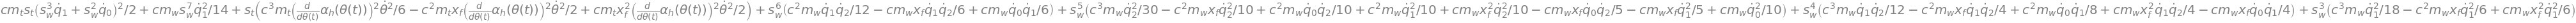

In [41]:
me.mechanics_printing()

# mass and inertia of the w_t
M_t = p.m_t.integrate((x,0,p.c),(y,0,p.s_t))
I_t = (p.m_t*y).integrate((x,0,p.c),(y,0,p.s_t))

T = (sym.Rational(1,2)*p.m_w*z_w.diff(t)**2).integrate((x,0,p.c),(y,0,p.s_w))
T = T + sym.Rational(1,2)*M_t*(kappa_w.diff(t).subs({y:p.s_w}))**2

T = T + (sym.Rational(1,2)*p.m_t*(z_t_local.diff(t))**2).integrate((x,0,p.c),(y,0,p.s_t))

T


In [42]:
I_t

In [43]:
# the potential energy of the wing is the same as before

U = sym.Rational(1,2)*((kappa_w.diff(y,y)**2*p.EI)
    .integrate((y,0,p.s_w)))
U = U + sym.Rational(1,2)*((alpha_w.diff(y)**2*p.GJ)
    .integrate((y,0,p.s_w)))

In [44]:
# create EoM
L = sym.Matrix([T-U])
term_1 = L.jacobian(qd).diff(t).T
term_2 = L.jacobian(q).T
LHS = term_1-term_2

M = sym.simplify(LHS.jacobian(qdd))

K = sym.simplify(LHS - M*qdd).jacobian(q)
K

⎡                         2                                                   
⎢4⋅EI⋅s_w         6⋅EI⋅s_w             0      0                               
⎢                                                                             
⎢        2      ⎛         2     ⎞         2                                   
⎢6⋅EI⋅s_w   s_w⋅⎝12⋅EI⋅s_w  + GJ⎠   GJ⋅s_w    0                               
⎢                                                                             
⎢                                          3                                  
⎢                        2         4⋅GJ⋅s_w                                   
⎢    0             GJ⋅s_w          ─────────  0                               
⎢                                      3                                      
⎢                                                                             
⎢    0                0                0      0                               
⎢                                                   

In [45]:
# how about with the classic method?
nonLinModel = AssumedShapes.SymbolicModel(q,z_w,alpha_w,z_t,alpha_t,p,coords-1)
nonLinModel.GenerateEoM()


In [46]:
sym.simplify(nonLinModel.K)

⎡                         2                                                   
⎢4⋅EI⋅s_w         6⋅EI⋅s_w             0      0                               
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢        2      ⎛         2     ⎞         2                                   
⎢6⋅EI⋅s_w   s_w⋅⎝12⋅EI⋅s_w  + GJ⎠   GJ⋅s_w    0                               
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [11]:
class NonlinearSymModel(AssumedShapes.SymbolicModel):
    def FwtPotentialEnergy(self):
        U = sym.Integer(0)
        return U
    def FwtKineticEnergy(self):
        M_t = self.p.m_t.integrate((x,0,self.p.c),(y,0,self.p.s_t))
        I_t = (self.p.m_t*y).integrate((x,0,self.p.c),(y,0,self.p.s_t))
        
        T = sym.Rational(1,2)*M_t*(self.kappa_w.diff(t).subs({y:self.p.s_w}))**2
        T = T + (sym.Rational(1,2)*self.p.m_t*(self.z_t.diff(t))**2).integrate((x,0,self.p.c),(y,0,self.p.s_t))
        return T

In [12]:
z_w =q0*y**2+q1*y**3+q2*y*(x-p.x_f)+q3*y**2*(x-p.x_f)
alpha_w = q2*y+q3*y**2

alpha_h = sym.Function('alpha_h')(theta)
z_t = alpha_h*(x-p.x_f)
alpha_t = alpha_h


nonLinModel = NonlinearSymModel(q,z_w,alpha_w,z_t,alpha_t,p,5)

In [13]:
nonLinModel.GenerateEoM()

In [16]:
nonLinModel.M

⎡     4                           5                                     4     
⎢c⋅s_w ⋅(5⋅mₜ⋅sₜ + m_w⋅s_w)  c⋅s_w ⋅(6⋅mₜ⋅sₜ + m_w⋅s_w)        c⋅m_w⋅s_w ⋅(c -
⎢──────────────────────────  ──────────────────────────        ───────────────
⎢            5                           6                               8    
⎢                                                                             
⎢     5                           6                                     5     
⎢c⋅s_w ⋅(6⋅mₜ⋅sₜ + m_w⋅s_w)  c⋅s_w ⋅(7⋅mₜ⋅sₜ + m_w⋅s_w)        c⋅m_w⋅s_w ⋅(c -
⎢──────────────────────────  ──────────────────────────        ───────────────
⎢            6                           7                               10   
⎢                                                                             
⎢           4                           5                         3 ⎛ 2       
⎢  c⋅m_w⋅s_w ⋅(c - 2⋅x_f)      c⋅m_w⋅s_w ⋅(c - 2⋅x_f)    c⋅m_w⋅s_w ⋅⎝c  - 3⋅c⋅
⎢  ──────────────────────      ─────────────────────

In [17]:
nonLinModel.GetGeneralisedWingForces()

⎛⎡              5                  6                                          
⎜⎢-V⋅a_w⋅c⋅ρ⋅s_w     -V⋅a_w⋅c⋅ρ⋅s_w                                           
⎜⎢────────────────   ────────────────          0                0         0  0
⎜⎢       10                 12                                                
⎜⎢                                                                            
⎜⎢              6                  7                                          
⎜⎢-V⋅a_w⋅c⋅ρ⋅s_w     -V⋅a_w⋅c⋅ρ⋅s_w                                           
⎜⎢────────────────   ────────────────          0                0         0  0
⎜⎢       12                 14                                                
⎜⎢                                                                            
⎜⎢       2        4         2        5         3      3         3      4      
⎜⎢V⋅a_w⋅c ⋅e⋅ρ⋅s_w   V⋅a_w⋅c ⋅e⋅ρ⋅s_w   M_α̇⋅V⋅c ⋅ρ⋅s_w   M_α̇⋅V⋅c ⋅ρ⋅s_w     
⎜⎢─────────────────  ─────────────────  ────────────

In [159]:
kappa_t = z_t.subs(x,p.x_f)
kappa_t_dt = theta.diff(t)*  
kappa_t_dt = theta.diff(t)*y + kappa_w.subs(p.s_w,0)*sym.cos(theta)
#((sym.Matrix([self.kappa_w])
#            .jacobian(self.q).T*dL_w)
#            .integrate((y,0,self.p.s_w)))

#w_g = me.dynamicsymbols('w_g')
ah = sym.Function('a_h')(theta)# sym.atan(sym.sin(p.Lambda)*sym.sin(theta))

dL_t = sym.Rational(-1,2)*p.rho*p.V**2*p.c*p.a_t* \
            (ah + kappa_t_dt/p.V)
dM_t = sym.Rational(1,2)*p.rho*p.V**2*p.c**2* \
    (p.e*p.a_t*
    (ah + kappa_t_dt/p.V)+
     0)#p.Malphadot*ah.diff(t)*p.c/(4*p.V))

# lift transmitted through the hinge
L_h = sym.simplify(dL_t.integrate((y,0,p.s_t)))*sym.cos(theta)

My_h = sym.simplify(dM_t.integrate((y,0,p.s_t)))*sym.cos(theta)
Mx_h = (dL_w*y).integrate((y,0,p.s_t))


# translating the hinge forces back onto the main wing

QL = sym.simplify(sym.Matrix([L_h*kappa_w.subs(y,p.s_w)]).jacobian(q).subs(alpha_h,theta*sym.sin(p.Lambda))).T
QMy = sym.simplify(sym.Matrix([My_h*alpha_w.subs(y,p.s_w)]).jacobian(q).subs(alpha_h,theta*sym.sin(p.Lambda))).T
QMx = sym.simplify(sym.Matrix([Mx_h*theta]).jacobian(q).subs(alpha_h,sym.sin(theta)*sym.sin(p.Lambda))).T




# moment thought the hinge 
# M_h = dM_w

In [171]:
#Q = (QL + QMy + QMx).T

#B = Q.jacobian(qd)

#r = sym.simplify(Q - B*qd)
Q = QMx.expand()+QL.expand()
B = Q.jacobian(qd)
qdict = {}
for i in qd:
    qdict[i] = 0
r = (Q.subs(qdict))
C = r.jacobian(q)
for i in q:
    qdict[i] = 0
Q.subs(qdict)
qdict = {}
for i in qd:
    qdict[i] = 0
Q.subs(qdict).jacobian(q)

B = Q.jacobian(qd)
C

⎡                                                                             
⎢                                                                             
⎢                                                                    -V⋅aₜ⋅c⋅ρ
⎢                                                                    ─────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                   4    2    
⎢                                                        V⋅aₜ⋅c⋅ρ⋅sₜ ⋅s_w ⋅cos
⎢                                                      - ─────────────────────
⎢                                                                    8        
⎢                                                                             
⎢                                                   

In [91]:
dL_w
ah = sym.atan(sym.sin(p.Lambda)*sym.sin(theta))
ah

In [83]:
sym.simplify(sym.Matrix([Q[5].expand()]) - sym.Matrix([Q[5].expand()]).jacobian(qd)*qd)

⎡         ⎛                   2                                               
⎢V⋅c⋅ρ⋅sₜ⋅⎝- 2⋅V⋅aₜ⋅α₀⋅c⋅e⋅s_w ⋅q₃⋅sin(θ) - 2⋅V⋅aₜ⋅α₀⋅c⋅e⋅s_w⋅q₂⋅sin(θ) - V⋅aₜ
⎢─────────────────────────────────────────────────────────────────────────────
⎣                                                                             

                      3                          2                           2
⋅α₀⋅sₜ + 2⋅V⋅aₜ⋅α₀⋅s_w ⋅q₁⋅sin(θ) + 2⋅V⋅aₜ⋅α₀⋅s_w ⋅q₀⋅sin(θ) - 2⋅V⋅aₜ⋅c⋅e⋅s_w 
──────────────────────────────────────────────────────────────────────────────
                                                                              

                                    2                                         
⋅q₃⋅θ⋅sin(Λ)⋅sin(θ) + 2⋅V⋅aₜ⋅c⋅e⋅s_w ⋅q₃⋅sin(Λ)⋅cos(θ) - 2⋅V⋅aₜ⋅c⋅e⋅s_w⋅q₂⋅θ⋅s
──────────────────────────────────────────────────────────────────────────────
                                                                              

                                                 